In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [13]:
metadata = pd.read_csv('HAM10000_metadata.csv')

In [14]:
print("Dataset Shape:", metadata.shape)
print("\nFirst 5 rows:")
print(metadata.head())

Dataset Shape: (10015, 7)

First 5 rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [16]:
print("\nColumn Info:")
metadata.info()


Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [17]:
print("\nClass Distribution:")
print(metadata['dx'].value_counts())


Class Distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [18]:
print("\nMissing Values:")
print(metadata.isnull().sum())


Missing Values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [21]:
print((metadata['age'].isnull().sum() / len(metadata)) * 100)
metadata['age'] = metadata['age'].fillna(metadata['age'].median())


0.5691462805791313


In [23]:
classes = np.unique(metadata['dx'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=metadata['dx']
)

class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)


{'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


C:\Users\khavy\AppData\Local\Temp\ipykernel_17628\2651979058.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


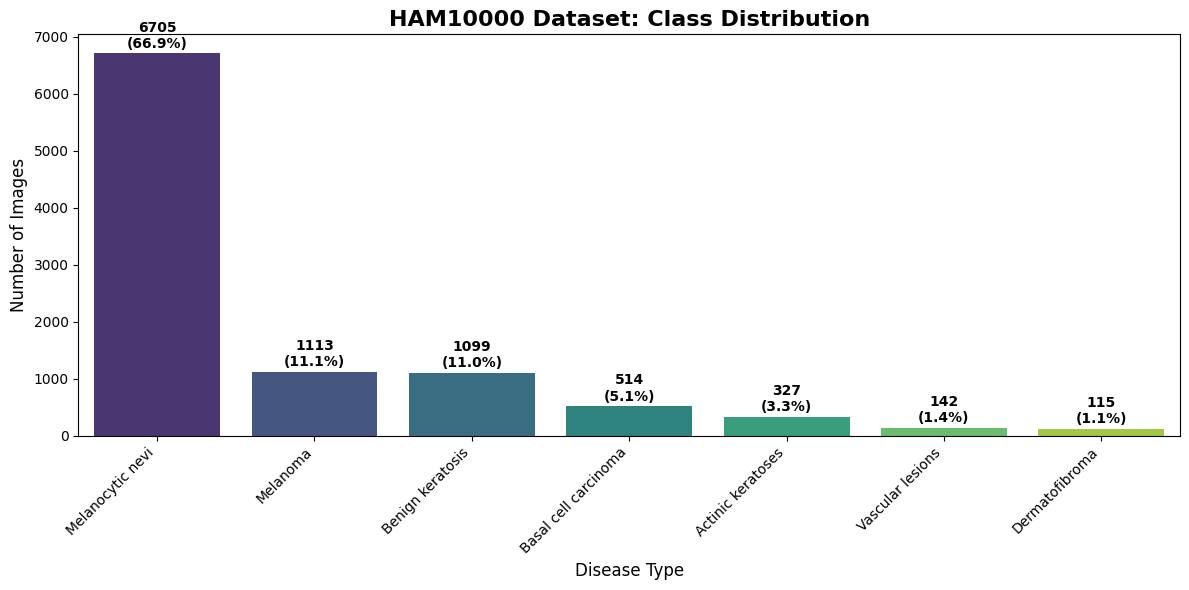


 Class Imbalance Ratio: 58.3:1


In [24]:
# Create disease name mapping
dx_mapping = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

metadata['dx_full'] = metadata['dx'].map(dx_mapping)

# Plot class distribution
plt.figure(figsize=(12, 6))
class_counts = metadata['dx_full'].value_counts()

ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('HAM10000 Dataset: Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Disease Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage labels on bars
total = len(metadata)
for i, (label, count) in enumerate(class_counts.items()):
    percentage = (count / total) * 100
    ax.text(i, count + 100, f'{count}\n({percentage:.1f}%)', 
            ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Class Imbalance Ratio: {class_counts.max() / class_counts.min():.1f}:1")

Total images in metadata: 10015
Images found on disk: 0
Missing images: 10015


TypeError: Can't convert object to 'str' for 'filename'

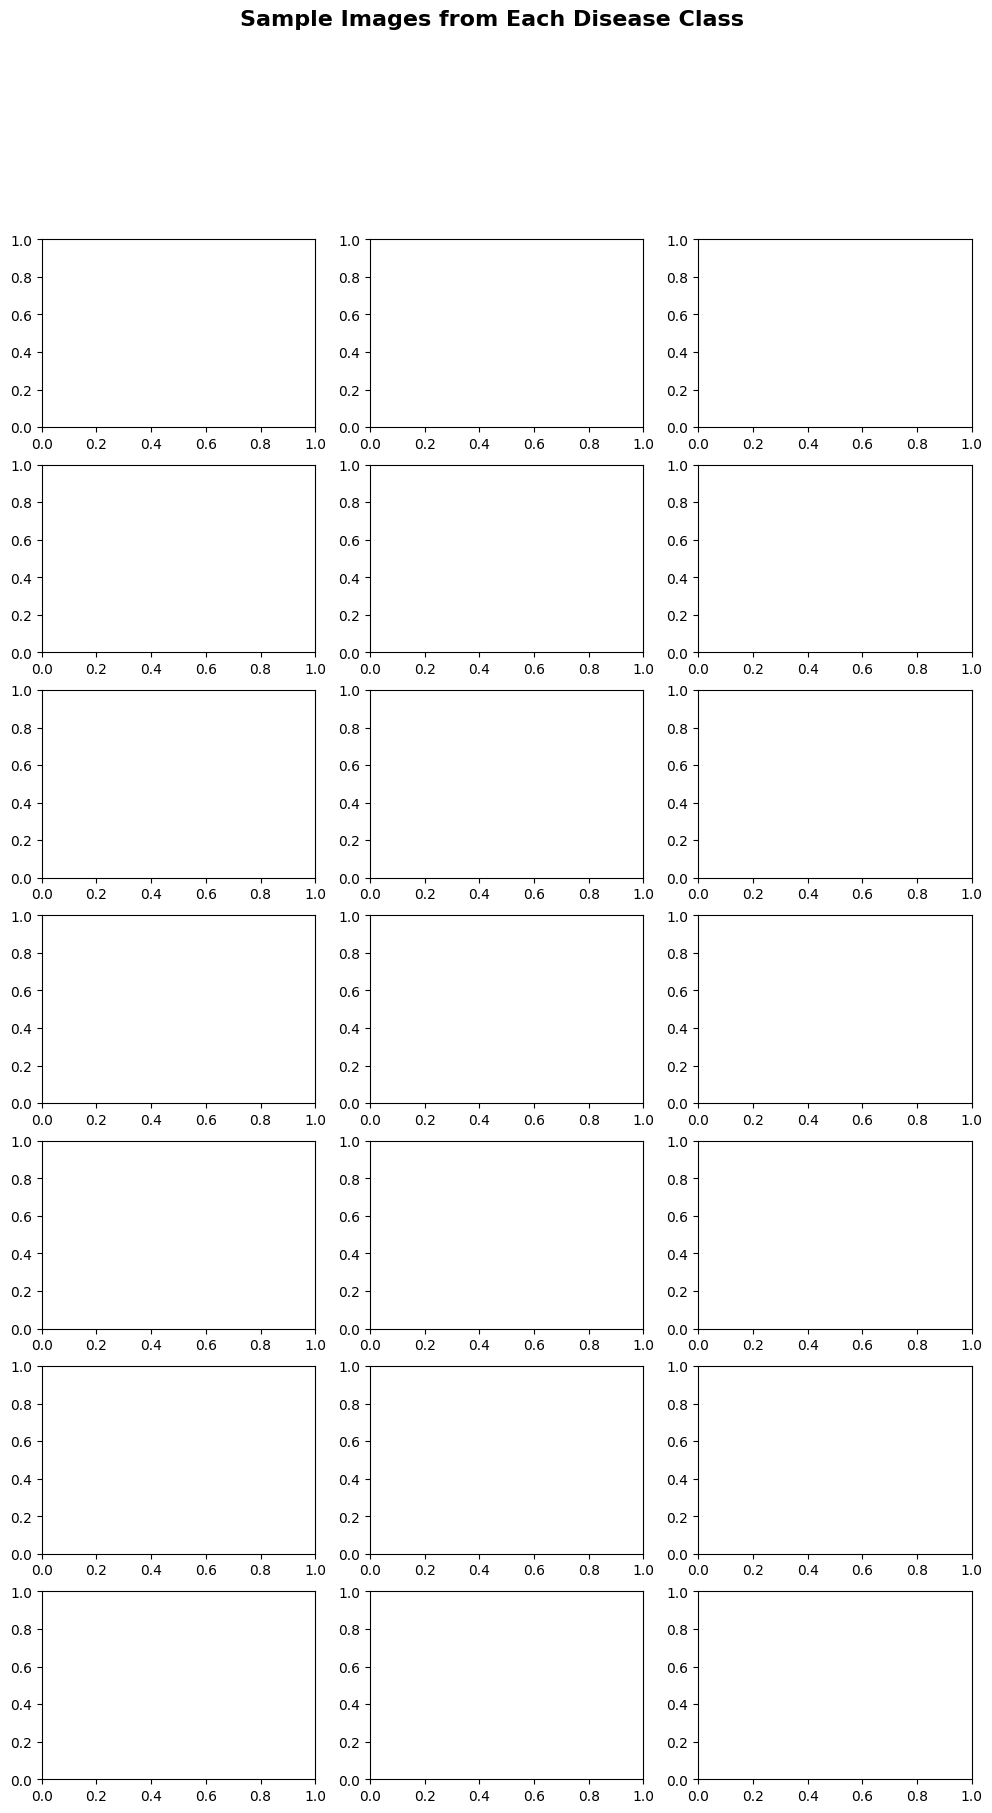

In [25]:
# Combine image paths (HAM10000 has images in two folders)
import glob

image_paths_1 = glob.glob('ham10000_data/HAM10000_images_part_1/*.jpg')
image_paths_2 = glob.glob('ham10000_data/HAM10000_images_part_2/*.jpg')
all_image_paths = image_paths_1 + image_paths_2

# Create image_id to path mapping
image_dict = {os.path.basename(path).split('.')[0]: path for path in all_image_paths}

# Add full path to metadata
metadata['image_path'] = metadata['image_id'].map(image_dict)

# Verify all images found
print(f"Total images in metadata: {len(metadata)}")
print(f"Images found on disk: {len(all_image_paths)}")
print(f"Missing images: {metadata['image_path'].isnull().sum()}")

# Visualize 3 random samples from each class
fig, axes = plt.subplots(7, 3, figsize=(12, 20))
fig.suptitle('Sample Images from Each Disease Class', fontsize=16, fontweight='bold', y=0.995)

for idx, (dx_code, dx_name) in enumerate(dx_mapping.items()):
    class_data = metadata[metadata['dx'] == dx_code]
    samples = class_data.sample(n=3, random_state=42)
    
    for col, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx, col].imshow(img)
        axes[idx, col].axis('off')
        
        if col == 0:
            axes[idx, col].set_title(f"{dx_name}\n({dx_code})", 
                                     fontsize=11, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()